In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2
import random

import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from random import shuffle
from sklearn import model_selection as sk_model_selection

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC

import tensorflow as tf

from skimage.metrics import structural_similarity as compare_ssim

In [2]:
data_directory = '../input/rsna-miccai-png'
mri_types = ['FLAIR','T1w','T1wCE','T2w']
IMAGE_SIZE = 256
NUM_IMAGES = 128
train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
train_df['BraTS21ID5'] = [format(x, '05d') for x in train_df.BraTS21ID]
train_df = train_df.loc[train_df.BraTS21ID!=109]
train_df = train_df.loc[train_df.BraTS21ID!=709]
train_df = train_df.loc[train_df.BraTS21ID!=123]
train_df = train_df.reset_index(drop=True)
train_df.head(3)

,BraTS21ID,MGMT_value,BraTS21ID5
0,0,1,00000
1,2,1,00002
2,3,0,00003


### Instead of feeding random N number of images of each patient to the model, we can feed images which contains the tumor. For that we need to first detect the tumor from the images.

## Tumor Detection using Opencv

In [3]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

def create_animation(ims):
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//24)

def get_gray(org_img):
    gray_img=cv2.cvtColor(org_img.copy(),cv2.COLOR_RGB2GRAY)
    return gray_img

def get_RGB(gray_img):
    rgb_img=cv2.cvtColor(gray_img.copy(),cv2.COLOR_GRAY2RGB)
    return rgb_img

def get_threshold(org_img,blur=False,erode=False,dilate=False):
    gray_img=get_gray(org_img.copy())
    if blur:
        img=cv2.GaussianBlur(gray_img.copy(), (5, 5), 0)
    img=cv2.threshold(img,5,255,cv2.THRESH_BINARY)[1]
    if erode:
        img=cv2.erode(img, None, iterations=2)
    if dilate:
        img=cv2.dilate(img, None, iterations=2)
    return img

def get_contours(th_img):
    cnts,_ = cv2.findContours(th_img.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    return cnts
   
def edge_smoothing(org_img,cnts):
    gray_img=get_gray(org_img.copy())
    if len(cnts)==0:  
        return gray_img
    c = max(cnts, key=cv2.contourArea)
    black_img=np.zeros_like(gray_img)
    black_cnt=cv2.drawContours(black_img.copy(),c,-1, (255, 255, 255), 2)
    black_cnt=cv2.dilate(black_cnt.copy(), None, iterations=10)
    white_cnt=cv2.bitwise_not(black_cnt.copy())
    white_cnt=get_RGB(white_cnt)
    smooth_img=cv2.bitwise_and(white_cnt.copy(),org_img.copy())
    return smooth_img

def get_iou(bb1, bb2):
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def check_overlapping(prev_cnt,curr_cnt):
    x,y,w,h=cv2.boundingRect(prev_cnt)
    bb1=[x,y,x+w,y+h]
    x,y,w,h=cv2.boundingRect(curr_cnt)
    bb2=[x,y,x+w,y+h]
    iou=get_iou(bb1,bb2)
    return iou
    

def load_patient_images(path,threshold=False,roi_threshold=False,matchpattern=False,template_path=None):
    t_paths = sorted(
        glob.glob(os.path.join(path, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )
    templates=[]
    if not template_path is None:
        for t_path in template_path:
            templates.append(cv2.imread(t_path))
    
    images = []
    for filename in t_paths:
        data = cv2.imread(filename)
        if data.max() == 0:
            continue
        images.append(data)
    
    mid_idx=len(images)//2
    th_middle_image=get_threshold(images[mid_idx].copy(),blur=True,erode=True,dilate=True)
    x1,y1,w1,h1=cv2.boundingRect(th_middle_image)
    print('-->',x1,y1,w1,h1)
    max_area=w1*h1
    
    images=np.array(images)
    new_images=[]
    if images[0].shape[0]<=256 or images[1].shape[0]<=256:
        t_size=1
    elif images[0].shape[0]>=500 or images[1].shape[0]>=500:
        t_size=3
    else:
        t_size=2
    print('text size: ',t_size)
     
    prev_cnt=0
    initialize_prev_cnt=False
    for i,data in enumerate(images):
        th_data=get_threshold(data.copy(),blur=True,erode=True,dilate=True)
        x,y,w,h=cv2.boundingRect(th_data)
        area=w*h
        ratio=area/max_area
        if ratio<0.4:
            continue
            
        org_cnts=get_contours(th_data.copy())
        if org_cnts:
            org_max = max(org_cnts, key=cv2.contourArea)
            org_cnts_area=cv2.contourArea(org_max)
        
        if matchpattern:
            image=data.copy()
            comm_image=image.copy()
            result=cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
            (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)
            (startX, startY) = maxLoc
            endX = startX + template.shape[1]
            endY = startY + template.shape[0]
        
        if roi_threshold:
            image=data.copy()
            g_image=cv2.cvtColor(image.copy(),cv2.COLOR_BGR2GRAY)
            thresh=g_image.mean()+((g_image.max()-g_image.mean())//3)
            th_data=cv2.threshold(g_image,thresh,g_image.max(),cv2.THRESH_BINARY)[1]
            g_image=cv2.putText(g_image,f"{i}",(20,25),3,1,(255,255,0),2) 
            data=np.hstack([g_image,th_data])   
        
        if threshold:
            image=data.copy()  
            
            g_image=cv2.cvtColor(image.copy(),cv2.COLOR_BGR2GRAY)
            mean_values=g_image[np.nonzero(g_image)]
            thresh=mean_values.mean()+((mean_values.max()-mean_values.mean())//2)
            smooth_image=edge_smoothing(image,org_cnts)
            smooth_image=cv2.putText(smooth_image,f"{i}",(20,25),t_size,1,(thresh+1,thresh+1,thresh+1),2)
            gray_smooth_image=get_gray(smooth_image)
            
            th_image=cv2.threshold(gray_smooth_image.copy(),thresh,g_image.max(),cv2.THRESH_BINARY)[1]
            cnts,_ = cv2.findContours(th_image.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
            c = max(cnts, key=cv2.contourArea)
            data=cv2.drawContours(image.copy(),c,-1, (0, 255, 255), 2)

        new_images.append(data)        
               
    return new_images

def get_images(i,mri_type,threshold=False,roi_threshold=False,matchpattern=False,template_path=None):
    patient_id=train_df['BraTS21ID5'][i]
    mgmt=train_df['MGMT_value'][i]
    path=f'{data_directory}/train/{patient_id}/{mri_type}'
    print('Path: ',path)
    print('MGMT: ',mgmt)
    images=load_patient_images(path,threshold,roi_threshold,matchpattern,template_path)
    print(np.array(images).shape)
    return images

### Play the video

Path:  ../input/rsna-miccai-png/train/00124/T1wCE
MGMT:  0
--> 35 38 154 191
text size:  1
(15, 256, 224, 3)


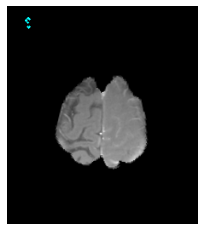

In [4]:
i=80
mri_type=mri_types[2]
images=get_images(i,mri_type,threshold=True)
create_animation(images)

Path:  ../input/rsna-miccai-png/train/00062/T1wCE
MGMT:  1
--> 100 109 346 282
text size:  3
(52, 512, 512, 3)


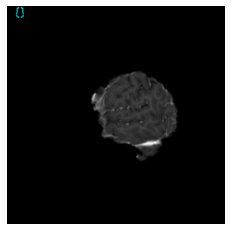

In [5]:
i=40
mri_type=mri_types[2]
images=get_images(i,mri_type,threshold=True)
create_animation(images)

## Data Pipeline 

### Image Resize with padding

(185, 163) 255


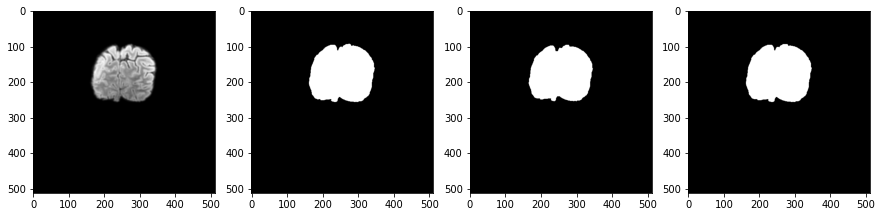

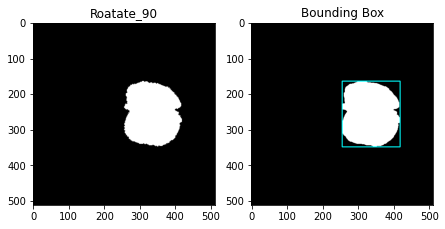

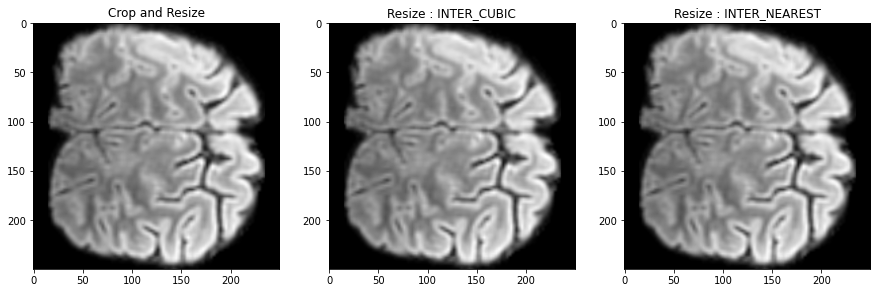

In [6]:
fig=plt.figure(figsize=(15,15))
path=glob.glob(f"{data_directory}/train/00777/FLAIR/*.png")
path=sorted(path,key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
img=cv2.imread(path[30])
org_img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img=cv2.GaussianBlur(org_img, (5, 5), 0)
plt.subplot(1,4,1)
plt.imshow(img,cmap='gray')

img=cv2.threshold(img,30,255,cv2.THRESH_BINARY)[1]
plt.subplot(1,4,2)
plt.imshow(img,cmap='gray')

img=cv2.erode(img, None, iterations=2)
plt.subplot(1,4,3)
plt.imshow(img,cmap='gray')

img=cv2.dilate(img, None, iterations=2)
plt.subplot(1,4,4)
plt.imshow(img,cmap='gray')

cv2.boundingRect(img)
fig=plt.figure(figsize=(15,15))
img=cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
org_img=cv2.rotate(org_img, cv2.ROTATE_90_CLOCKWISE)
cnts,_ = cv2.findContours(img.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
c = max(cnts, key=cv2.contourArea)
c_img=cv2.drawContours(img.copy(),c,-1, (0, 255, 255), 2)
plt.subplot(1,4,1)
plt.title('Roatate_90')
plt.imshow(c_img,cmap='gray')

x,y,w,h=cv2.boundingRect(c)
img_3ch=cv2.cvtColor(img.copy(),cv2.COLOR_GRAY2RGB)
rect_c_img=cv2.rectangle(img_3ch.copy(),(x,y),(x+w,y+h),(0,255,255),2)
plt.subplot(1,4,2)
plt.title('Bounding Box')
plt.imshow(rect_c_img,cmap='gray')

new_size=250
if (w*h)/(img.shape[0]*img.shape[1])>0.10:
    cropp_img=org_img[y:y+h,x:x+w]
    print(cropp_img.shape,cropp_img.max())
    resize_img=cv2.resize(cropp_img,(new_size,new_size))
    
desired_size = 250
im = cropp_img.copy()
old_size = im.shape
ratio = float(desired_size)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])
im = cv2.resize(im, (new_size[1], new_size[0]))
im2 = cv2.resize(im, (new_size[1], new_size[0]),interpolation=cv2.INTER_CUBIC)
im3 = cv2.resize(im, (new_size[1], new_size[0]),interpolation=cv2.INTER_NEAREST)
delta_w = desired_size - new_size[1]
delta_h = desired_size - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)
color = [0, 0, 0]
new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
new_im2 = cv2.copyMakeBorder(im2, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
new_im3 = cv2.copyMakeBorder(im3, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
fig=plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Crop and Resize')
plt.imshow(new_im,cmap='gray')
plt.subplot(132)
plt.title('Resize : INTER_CUBIC')
plt.imshow(new_im2,cmap='gray')
plt.subplot(133)
plt.title('Resize : INTER_NEAREST')
plt.imshow(new_im3,cmap='gray')

(1, 256, 256, 128)
0.0 1.0 0.09371103 0.0
Dimension of the CT scan is: (256, 256, 128)


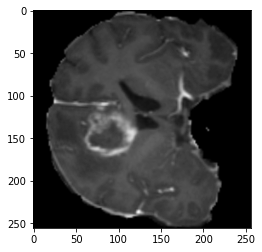

In [7]:
def resize_padding(crop_img,desired_size,x,y,w,h):
    
    im = crop_img.copy()
    old_size = im.shape
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im2 = cv2.resize(im, (new_size[1], new_size[0]),interpolation=cv2.INTER_CUBIC)
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im2 = cv2.copyMakeBorder(im2, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im2
    
def crop_resize_img(img,desired_size):
    
    org_img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img=cv2.GaussianBlur(org_img.copy(), (5, 5), 0)
    img=cv2.threshold(img,5,255,cv2.THRESH_BINARY)[1]
    img=cv2.erode(img, None, iterations=2)
    img=cv2.dilate(img, None, iterations=2)
    x,y,w,h=cv2.boundingRect(img)
    if (w*h)/(img.shape[0]*img.shape[1])<0.10:
        return False,[]     
    crop_img=org_img[y:y+h,x:x+w]
    final_img=resize_padding(crop_img,desired_size,x,y,w,h)
    return True,final_img

    
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=False,rotate=0,rot_choice=None):
    
    data=cv2.imread(path)   
    if rotate > 0:
        print('yes')
        data = cv2.rotate(data, rot_choice)
    flag,data=crop_resize_img(data,img_size)
    return flag,data

def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, mri_type="FLAIR", split="train", rotate=0):

    rot_choice=None
    if rotate>0:
        rot_choices = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        rot_choice=random.choice(rot_choices)
        
    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.png"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    
    img3d=[]
    for i,f in enumerate(files):
        flag,data=load_dicom_image(f,rotate=rotate,rot_choice=rot_choice)
        if not flag:
            continue
        if data.sum()==0:
            continue
        img3d.append(data)
    img3d=np.array(img3d).T
        
    if img3d.shape[-1] > num_imgs:
        diff = img3d.shape[-1] - num_imgs
        half_diff = diff//2
        p1 = half_diff
        p2 = img3d.shape[-1]-half_diff
        img3d=img3d[:,:,p1:p2]
        if img3d.shape[-1]>num_imgs:
            img3d=img3d[:,:,:num_imgs]
            
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
    
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    img3d=img3d.astype('float32')
    return np.expand_dims(img3d,0)

a = load_dicom_images_3d("00003",rotate=0,mri_type=mri_types[2]) #200, 148
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 50]), cmap="gray")